In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [16]:
df = pd.read_csv("D:\\INTERN PROGRAM\\Dataset .csv")


In [17]:
df = df.drop_duplicates()
df = df.dropna(subset=["Aggregate rating"])


In [18]:
columns_to_drop = ['Restaurant Name', 'Address', 'Locality', 'Menu', 'Phone']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')


In [19]:
df.loc[:, "Cuisines"] = df["Cuisines"].fillna("Unknown")
df.loc[:, "Rating text"] = df["Rating text"].fillna("Not rated")


In [20]:
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numerical_cols.remove("Aggregate rating")


In [21]:
X = df.drop("Aggregate rating", axis=1)
y = df["Aggregate rating"]


In [22]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])


In [23]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Restaurant ID',
                                                   'Country Code', 'Longitude',
                                                   'Latitude',
                                                   'Average Cost for two',
                                                   'Price range', 'Votes']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['City', 'Locality Verbose',
                                                   'Cuisines', 'Currency',
                                                   'Has Table booking',
                                                   'Has Online delivery',
                                                   'Is delivering now',
                                                   'Switch to order menu',
                                                   'Rating color',
                                                   'Rating text'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [26]:
y_pred = model.predict(X_test)


In [27]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error: 0.03
Root Mean Squared Error: 0.16
R² Score: 0.99


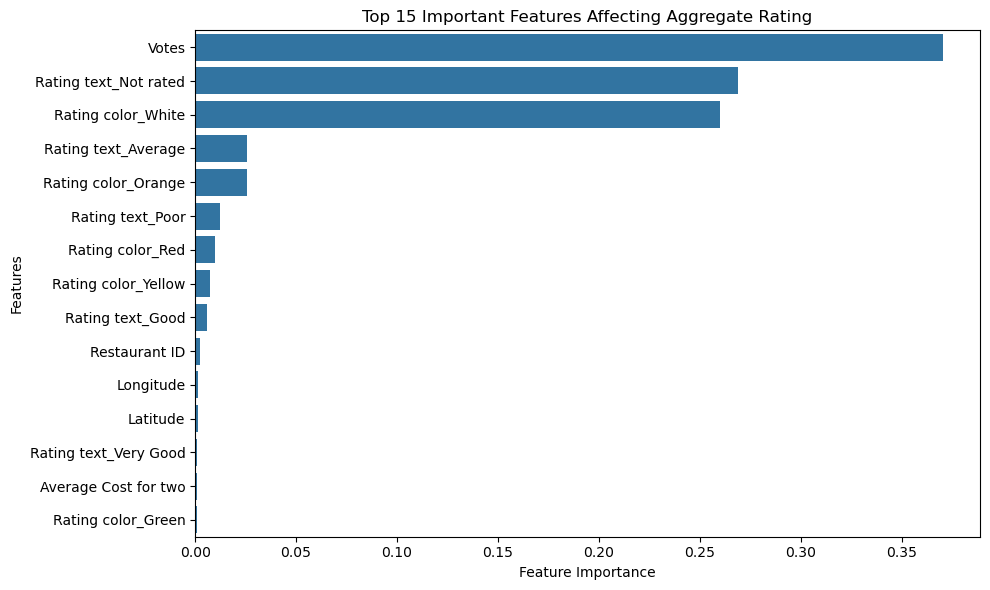

In [28]:
encoder = model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
encoded_cat_cols = encoder.get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(encoded_cat_cols)

importances = model.named_steps["regressor"].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 15 Important Features Affecting Aggregate Rating")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()
